In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from joblib import load
from matplotlib.patches import Patch

In [111]:
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (15,12)

In [99]:
RANDOM_STATE = 42

In [100]:
def one_hot_encode_sequences(df, column_name):
    # Define a mapping from amino acids to integers
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    amino_acid_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    num_amino_acids = len(amino_acids)

    encoded_sequences = []

    for sequence in df[column_name]:
        # Initialize a matrix of zeros
        encoded_matrix = np.zeros((len(sequence), num_amino_acids), dtype=int)

        for i, aa in enumerate(sequence):
            if aa in amino_acid_to_int:
                # Set the corresponding column to 1
                encoded_matrix[i, amino_acid_to_int[aa]] = 1
            else:
                raise ValueError(f"Invalid amino acid '{aa}' found in sequence.")

        encoded_sequences.append(encoded_matrix)

    return encoded_sequences

# GB1

In [101]:
score_combined = pd.read_csv('gb1/gb1_designs.csv', index_col=0)
score_combined.head()

,SCORE:_score,total_score,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,dSASA_polar,...,binder_aligned_rmsd,pae_binder,pae_interaction,pae_target,plddt_binder,plddt_target,plddt_total,target_aligned_rmsd,time,description_af2
0,SCORE:,-778.570,-2.972,-50.466,-3.212,-43.526,-2.770,833.748,1571.393,737.644,...,0.634,4.938,11.953,13.861,88.372,90.086,89.720,8.606,21.103,gb1_IgG1FC_relax_best_0001_af2pred
1,CORE:,-771.852,-2.946,-49.671,-3.125,-42.744,-2.689,846.352,1589.353,743.002,...,0.722,5.408,12.334,13.970,86.834,89.399,88.851,9.434,20.684,gb1_IgG1FC_relax_best_0002_af2pred
2,SCORE:,-778.996,-2.973,-51.969,-3.190,-44.942,-2.758,867.091,1629.332,762.241,...,0.705,5.403,12.293,13.976,86.711,88.529,88.141,10.846,20.659,gb1_IgG1FC_relax_best_0013_af2pred
3,SCORE:,-778.655,-2.972,-51.565,-3.214,-44.358,-2.764,867.628,1604.568,736.940,...,0.635,4.877,12.082,14.015,88.646,87.114,87.442,7.265,20.545,gb1_IgG1FC_relax_best_0132_af2pred
4,SCORE:,-767.049,-2.928,-50.952,-3.131,-43.959,-2.701,849.138,1627.330,778.192,...,0.721,5.427,12.319,13.975,86.738,89.235,88.701,10.366,21.056,gb1_IgG1FC_relax_best_0405_af2pred


## lookup fitness

In [102]:
df_GB1 = pd.read_csv('gb1/gb1_mutations_full_data.csv')
df_GB1['trunc_seq'] = df_GB1['sequence'].apply(lambda seq: 'MTYKLIL'+seq[7:56]) # truncated it to the PDB sequence
df_GB1

/home/iwe3/anaconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Variants,HD,Count input,Count selected,Fitness,sequence,keep,one_vs_rest,one_vs_rest_validation,two_vs_rest,two_vs_rest_validation,three_vs_rest,three_vs_rest_validation,sampled,sampled_validation,low_vs_high,low_vs_high_validation,trunc_seq
0,VDGV,0,92735,338346,1.000000,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,True,train,NaN,train,NaN,train,NaN,train,NaN,test,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...
1,ADGV,1,34,43,0.061910,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGADGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGADGEWTYD...
2,CDGV,1,850,641,0.242237,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGCDGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGCDGEWTYD...
3,DDGV,1,63,63,0.006472,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGDDGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGDDGEWTYD...
4,EDGV,1,841,190,0.032719,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEDGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEDGEWTYD...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149356,YYYR,4,203,1,0.001350,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...
149357,YYYS,4,186,3,0.004421,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...
149358,YYYT,4,181,14,0.021200,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...
149359,YYYW,4,30,1,0.009136,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...


In [103]:
fitness_list = []
counter = 0
for sequence in score_combined.sequence:
    lookup_df = df_GB1[df_GB1['trunc_seq'] == sequence]
    if lookup_df.empty:
        fitness_list.append(pd.NA) # only ones that weren't creatable in the lab are missing
    else:
        counter += 1
        fitness_list.append(lookup_df['Fitness'].values[0])
        
print(f'Sequence match found {counter} times!')
score_combined['Fitness'] = fitness_list


Sequence match found 2974 times!


In [104]:
score_combined = score_combined[~score_combined.Fitness.isna()].copy()

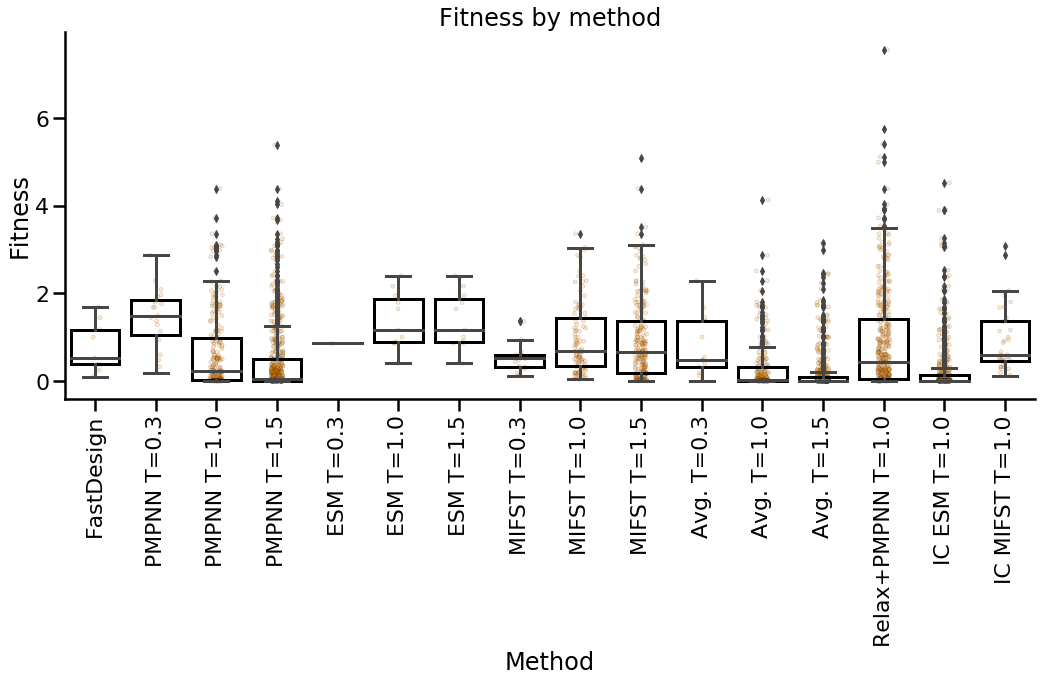

In [106]:
ax = sns.boxplot(y='Fitness', x='method', data=score_combined, 
                 boxprops=dict(facecolor='none', edgecolor='k'))
ax = sns.stripplot(y='Fitness', x='method', data=score_combined, 
                   color='darkorange', alpha=0.2, edgecolor='k', size=4, linewidth=0.5, zorder=0)


#plt.ylim(-2200, -1400)
plt.title('Fitness by method')
plt.xticks(rotation=90)
plt.ylabel('Fitness')
plt.xlabel('Method')
sns.despine(trim=False, right=True)
plt.tight_layout()
#plt.savefig('./gb1/binding_boxplot_known_mutations.png', dpi=400)

/home/iwe3/anaconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


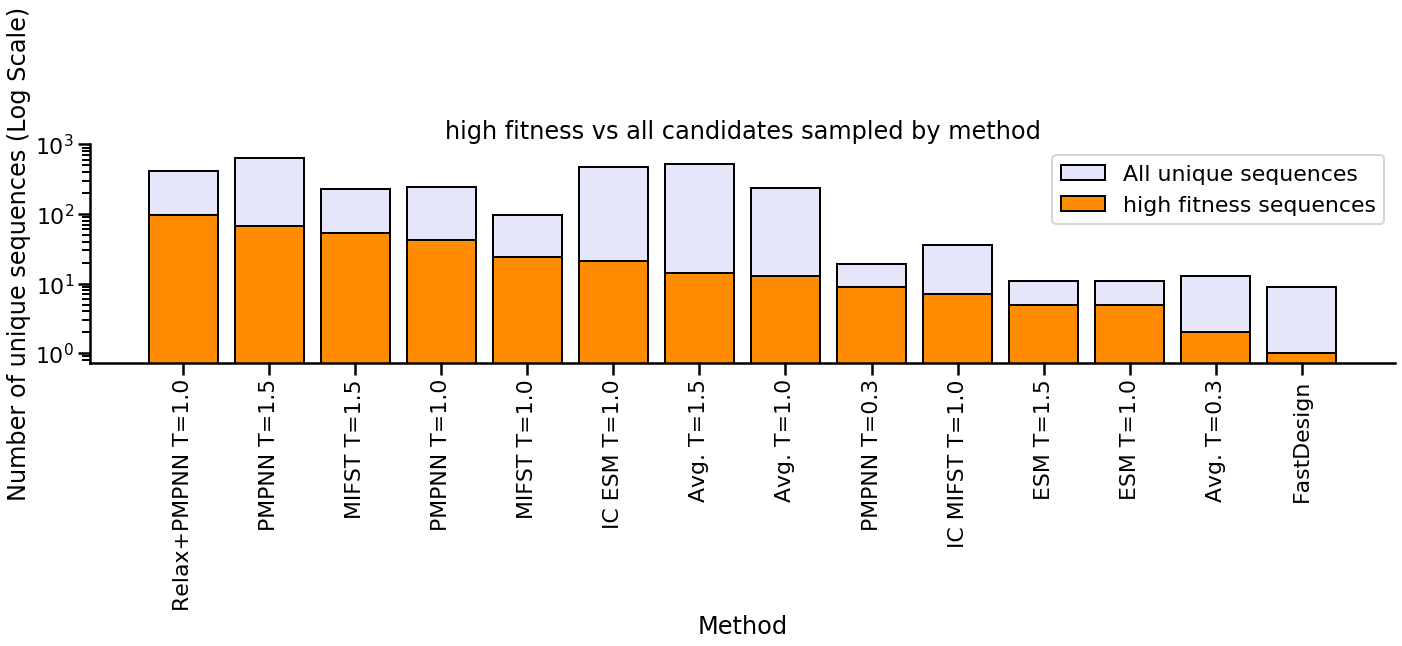

In [112]:
total_counts = score_combined.method.value_counts(sort=False)

# Count the number of rows for each method where ANT_score > 0.9
method_counts = score_combined[(score_combined.Fitness > 1.5)].method.value_counts(sort=False)

# Align the indices of total_counts to match those of method_counts
aligned_total_counts = total_counts.reindex(method_counts.index, fill_value=0)

# Normalize method_counts by aligned_total_counts to get the fraction
fraction_counts = method_counts / aligned_total_counts

# Multiply by 100 to convert to percentage
percentage_counts = fraction_counts * 100

# Sort both method_counts and percentage_counts by method_counts in descending order
sorted_indices = method_counts.sort_values(ascending=False).index
sorted_percentage_counts = percentage_counts.reindex(sorted_indices)
# Reindex both counts according to sorted_indices
sorted_total_counts = aligned_total_counts.reindex(sorted_indices)
sorted_method_counts = method_counts.reindex(sorted_indices)

# Create figure and subplot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the total counts
ax.bar(sorted_total_counts.index, sorted_total_counts, label='Total Candidates', color='lavender', edgecolor='black')

# Overlay the specific binders
ax.bar(sorted_method_counts.index, sorted_method_counts, label='Specific Binders', color='darkorange', edgecolor='black')

# Set log scale for y-axis
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Number of unique sequences (Log Scale)')
plt.title('high fitness vs all candidates sampled by method')

plt.ylim(0, 1000)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

legend_elements = [Patch(facecolor='lavender', edgecolor='black', label='All unique sequences'),
                   Patch(facecolor='darkorange', edgecolor='black', label='high fitness sequences')]


plt.legend(handles=legend_elements, loc='upper right')



sns.despine()
plt.tight_layout()
#plt.savefig('./gb1/binding_stacked_barplot_log_scale_known_mutations".svg', dpi=300)
plt.show()

## check correlation of metrics with fitness

In [92]:
print(spearmanr(score_combined.Fitness, score_combined.total_score))
print(spearmanr(score_combined.Fitness, score_combined.dG_separated))
print(spearmanr(score_combined.Fitness, score_combined.delta_unsatHbonds))
print(spearmanr(score_combined.Fitness, score_combined.sc_value))
print(spearmanr(score_combined.Fitness, score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(score_combined.Fitness, score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(score_combined.Fitness, score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(score_combined.Fitness, score_combined.plddt_binder))
print(spearmanr(score_combined.Fitness, score_combined.binder_aligned_rmsd))
print(spearmanr(score_combined.Fitness, score_combined.pae_interaction))


SpearmanrResult(correlation=-0.6354209224262645, pvalue=0.0)
SpearmanrResult(correlation=-0.41632741891987235, pvalue=5.035254864142716e-125)
SpearmanrResult(correlation=-0.1803815066100933, pvalue=3.608186587814254e-23)
SpearmanrResult(correlation=-0.028880610086817735, pvalue=0.11533659316741497)
SpearmanrResult(correlation=0.09541612724579328, pvalue=1.8564006542288063e-07)
SpearmanrResult(correlation=-0.7172532639227445, pvalue=0.0)
SpearmanrResult(correlation=-0.4633780902878243, pvalue=3.206161291075295e-158)
SpearmanrResult(correlation=0.23842149880225855, pvalue=1.0380472004538385e-39)
SpearmanrResult(correlation=-0.1954093827638894, pvalue=5.558831044489164e-27)
SpearmanrResult(correlation=-0.03014403742313573, pvalue=0.10026522546525933)


## check ranking power of different metrics

In [93]:
score_combined['avg_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mifst_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mpnn_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_mifst_mpnn_pp'] = score_combined[['mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)

In [94]:
for metric in ['total_score','dG_separated','sc_value','esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric','avg_pp','plddt_binder','binder_aligned_rmsd','pae_interaction']:
    if metric in ['sc_value','plddt_binder']:
        top_10 = score_combined.sort_values(metric, ascending=False)[:10].copy()
    else:
        top_10 = score_combined.sort_values(metric)[:10].copy()
    print(metric)
    print('Mean Fitness of Top 10:', top_10.Fitness.mean())
    print('Median Fitness of Top 10:', top_10.Fitness.median())
    print('Max Fitness of Top 10:', top_10.Fitness.max())
    print()

total_score
Mean Fitness of Top 10: 1.0727925719058702
Median Fitness of Top 10: 1.103714225475
Max Fitness of Top 10: 2.16359335977

dG_separated
Mean Fitness of Top 10: 0.4681109185966429
Median Fitness of Top 10: 0.1084809967765
Max Fitness of Top 10: 1.7614351768099998

sc_value
Mean Fitness of Top 10: 0.148839157512612
Median Fitness of Top 10: 0.013149319254299997
Max Fitness of Top 10: 1.39207351787

esm_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 0.48947200666905
Median Fitness of Top 10: 0.1872144183715
Max Fitness of Top 10: 2.7584195825599997

mifst_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 0.9092899383726639
Median Fitness of Top 10: 0.7892750150795
Max Fitness of Top 10: 2.48158643313

mpnn_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 1.3470710756163
Median Fitness of Top 10: 1.279947173385
Max Fitness of Top 10: 2.26023771846

avg_pp
Mean Fitness of Top 10: 0.68560090409795
Median Fitness of Top 10: 0.1872144183715
Max Fitness of Top 10: 2.7